In [1]:
%pip install -e ..

Obtaining file:///Users/arjunraj/code/SGanalysis
  Preparing metadata (setup.py) ... done
  Attempting uninstall: SGanalysis
    Found existing installation: SGanalysis 0.1.0
    Uninstalling SGanalysis-0.1.0:
      Successfully uninstalled SGanalysis-0.1.0
  Running setup.py develop for SGanalysis
Note: you may need to restart the kernel to use updated packages.


In [19]:
import numpy as np
import scanpy as sc
import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import json
from rasterio import features
import pprint

from SGanalysis.SGobject import SGobject


Here's some data from Yael that comes directly from the Spatial Genomics machine as masks in a tiff.

In [3]:
sg_obj = SGobject()

# Convert a TIFF image to polygons and store them in a GeoDataFrame
print("Running mask_to_objects...")
sg_obj.mask_to_objects('/Users/arjunraj/code/convert_masks_SG/segment_20231115_cells.tiff')

Running mask_to_objects...


In [4]:
spot_file = '/Users/arjunraj/code/convert_masks_SG/transcripts_no_segmentation.csv'
sg_obj.load_points(spot_file)

In [5]:
# Number of objects in the gdf
print("Number of objects in the gdf: ", len(sg_obj.gdf))
print(sg_obj.gdf.head())

Number of objects in the gdf:  12011
  object_id                                            nucleus
0        28  POLYGON ((17368.000 0.000, 17486.000 0.000, 17...
1        18  POLYGON ((31827.000 0.000, 31979.000 0.000, 31...
2        23  POLYGON ((14546.000 0.000, 14671.000 0.000, 14...
3         1  POLYGON ((0.000 0.000, 0.000 77.000, 12.000 82...
4         9  POLYGON ((31410.000 0.000, 31573.000 0.000, 31...


In [6]:
# Number of points in the points_gdf
print("Number of points in the points_gdf: ", len(sg_obj.points_gdf))
print(sg_obj.points_gdf.head())

Number of points in the points_gdf:  10345711
    name               refid     x   y                 geometry
0  Nupr1  ENSMUSG00000030717    82  91    POINT (82.000 91.000)
1  Nupr1  ENSMUSG00000030717  2551  72  POINT (2551.000 72.000)
2  Nupr1  ENSMUSG00000030717  2441  97  POINT (2441.000 97.000)
3  Nupr1  ENSMUSG00000030717  3022  36  POINT (3022.000 36.000)
4  Nupr1  ENSMUSG00000030717  3187  44  POINT (3187.000 44.000)


In [7]:
# Assign points to cells
sg_obj.create_cell_gene_table()
cell_gene_table_df = sg_obj.get_cell_gene_table_df() # Table is an AnnData object, convert to dataframe for easy use
print("Length of cell_gene_table_df: ", len(cell_gene_table_df))
print(cell_gene_table_df.head())

4235747 of 10323626 spots (41.0%) assigned to an object.
No filtering available or applied.
Length of cell_gene_table_df:  12007
name       Ada  Add3  Adh6a  Agr2  Ahnak  Aldh1b1  Aldob  Alpi  Ang4  Anxa1  \
object_id                                                                     
1            0     0      0     0      0        0      0     0     0      0   
10           0     0      0     0     23        0      0     0     0      6   
100          0     0      0     0     38        1      1     0     0     36   
1000         4     0      0     0     20        0      0     0     0      0   
10000        0     0      0     0    188        0      1     0     0      0   

name       ...  Tff3  Tm4sf20  Tm4sf4  Tph1  Tuba1a  Txndc5  Vim  Yap1  \
object_id  ...                                                           
1          ...     0        0       0     0       0       0    0     0   
10         ...     0        0       1     0       0       0    0     2   
100        ...     0 

In [8]:
# This should be a table of just the cell by gene expression values. Again, rarely directly used.
print(sg_obj.cell_gene_table.X)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  2  1  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [54  0  1 ...  1  0  1]
 [16  0  0 ...  0  1 80]
 [ 8  0  0 ...  2  1  0]]


In [11]:
# The "obs" column should be the object_id.
print(sg_obj.cell_gene_table.obs)

Empty DataFrame
Columns: []
Index: [1, 10, 100, 1000, 10000, 10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10009, 1001, 10010, 10011, 10012, 10013, 10014, 10015, 10016, 10017, 10018, 10019, 1002, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 1003, 10030, 10031, 10032, 10033, 10034, 10035, 10036, 10037, 10038, 10039, 1004, 10040, 10041, 10042, 10043, 10044, 10045, 10046, 10047, 10048, 10049, 1005, 10050, 10051, 10052, 10053, 10054, 10055, 10056, 10057, 10058, 10059, 1006, 10060, 10061, 10062, 10063, 10064, 10065, 10066, 10067, 10068, 10069, 1007, 10070, 10071, 10072, 10073, 10074, 10075, 10076, 10077, 10078, 10079, 1008, 10080, 10081, 10082, 10083, 10084, 10085, 10086, 10087, ...]

[12007 rows x 0 columns]


Now we can generate some statistics and histograms. Note that the number of objects here is 12011, but the length of the dataframe is 12007. The discrepancy arises from a few objects that have zero points in them.

Number of objects: 12011
Number of points: 10345711
Average number of points per object: 861.35
Percentage of points assigned to an object: 40.94%
Average number of assigned points per object: 352.66
Average number of unique genes detected per object: 37.46
Total number of genes detected: 140
Total number of genes detected (assigned to objects): 140


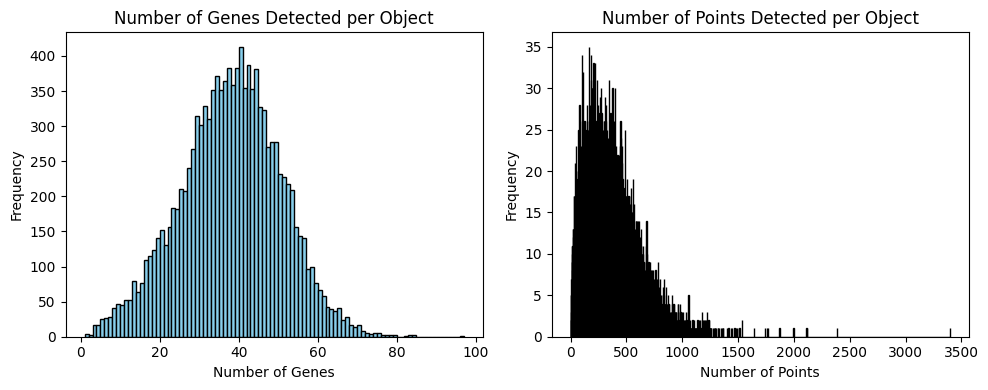

In [12]:
sg_obj.generate_statistics_and_histograms()

No filtering available or applied.


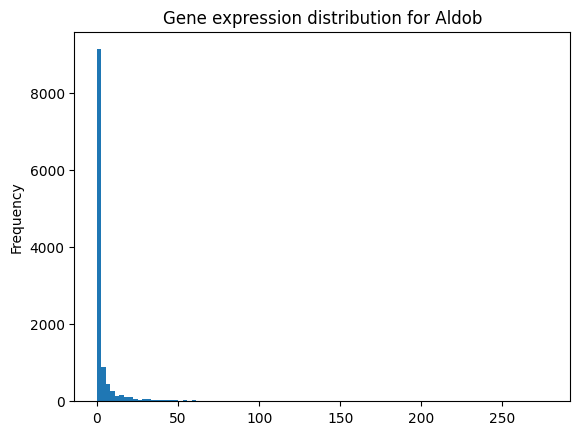

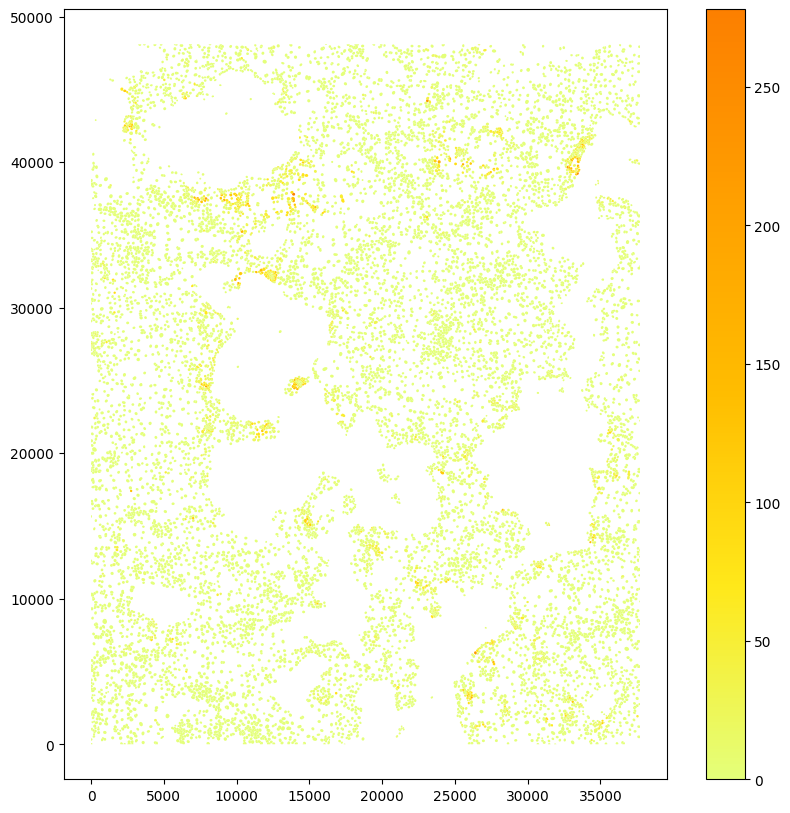

Statistics for gene Aldob: count    12007.000000
mean         5.154243
std         16.147198
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        278.000000
Name: Aldob, dtype: float64
Number of objects expressing Aldob: 4739 out of 12007 (39.47%)


In [13]:
sg_obj.show_gene_stats_plots("Aldob")

No filtering available or applied.


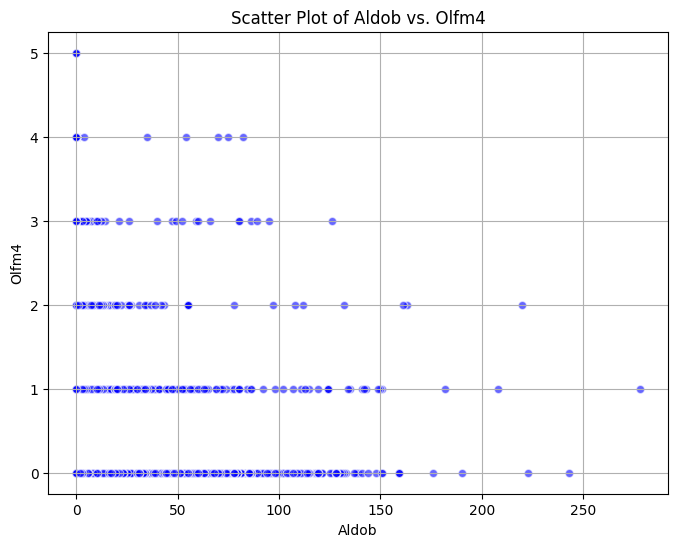

In [14]:
# Plot a scatter of Aldob vs. Lgr5
sg_obj.plot_gene_scatter("Aldob", "Olfm4")

No filtering available or applied.


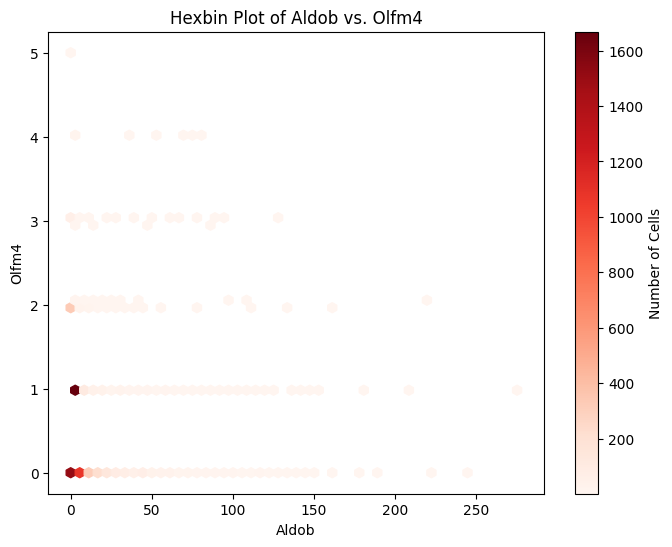

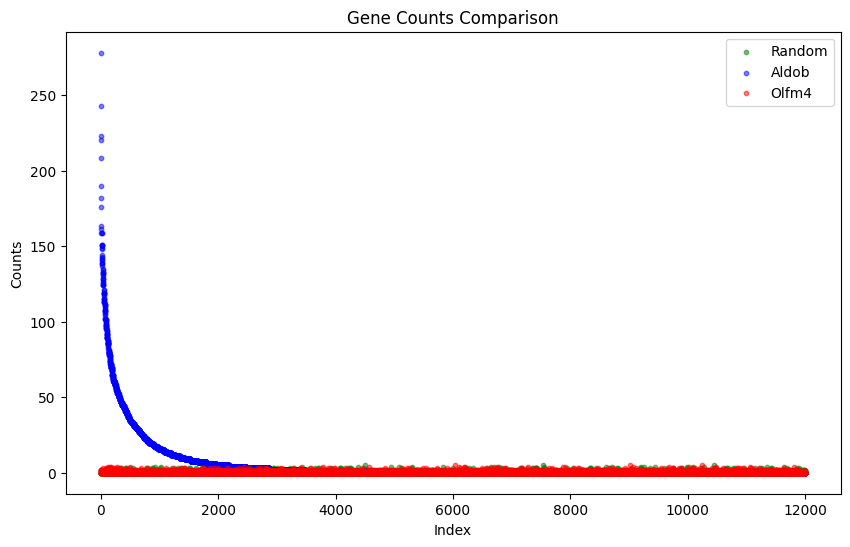

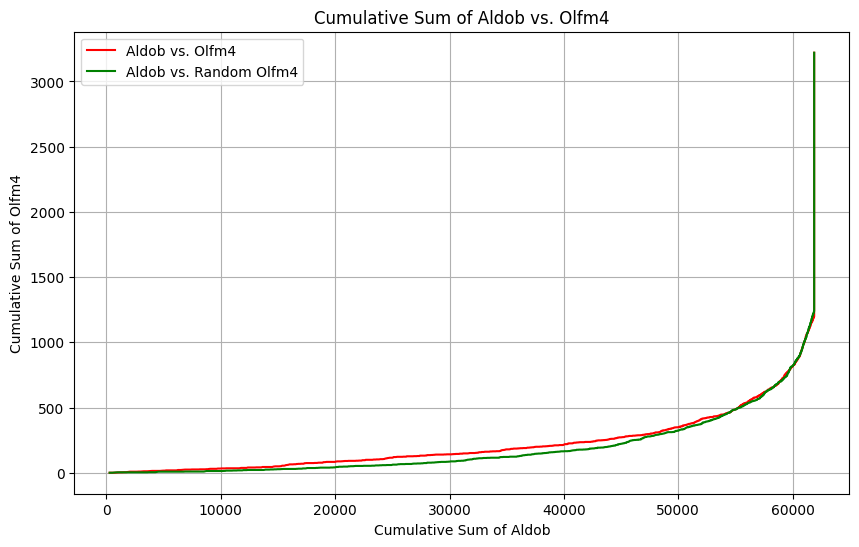

(0.00978593322813258, 0.06760990553108867)

In [9]:
# This is an old way to calculate the L-metric. See below for a new way. Leaving this here for documentation.

sg_obj.l_metric("Aldob", "Olfm4", plot_cumulative_sum=True, plot_gene_counts=True, plot_hexbin=True)

# Demonstration of the L-metric calculator.

In [13]:
# Replace with your path
%pip install -r /Users/arjunraj/code/l-metric/requirements.txt
%pip install -e /Users/arjunraj/code/l-metric/

Note: you may need to restart the kernel to use updated packages.
Obtaining file:///Users/arjunraj/code/l-metric
  Preparing metadata (setup.py) ... done
  Attempting uninstall: l-metric-calculator
    Found existing installation: l-metric-calculator 0.1.0
    Uninstalling l-metric-calculator-0.1.0:
      Successfully uninstalled l-metric-calculator-0.1.0
  Running setup.py develop for l-metric-calculator
Note: you may need to restart the kernel to use updated packages.


In [14]:
from l_metric_calculator.l_metric_calculator import LMetricCalculator

In [16]:
# Initialize the LMetricCalculator with the DataFrame
calculator = LMetricCalculator(cell_gene_table_df)

# Calculate the L-metric for the specified gene pairs
l_metric_values = calculator.compute_l_metric("Aldob", "Olfm4")

# Print the calculated L-metric values
print(l_metric_values)


(0.00845190748877412, 0.06760990553108867)


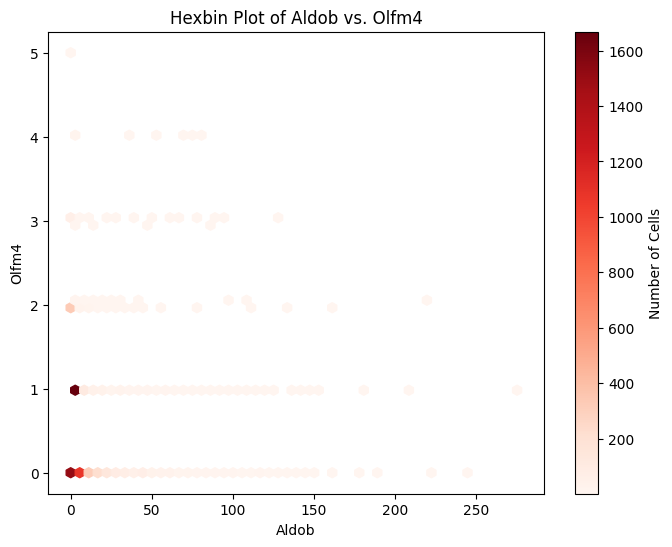

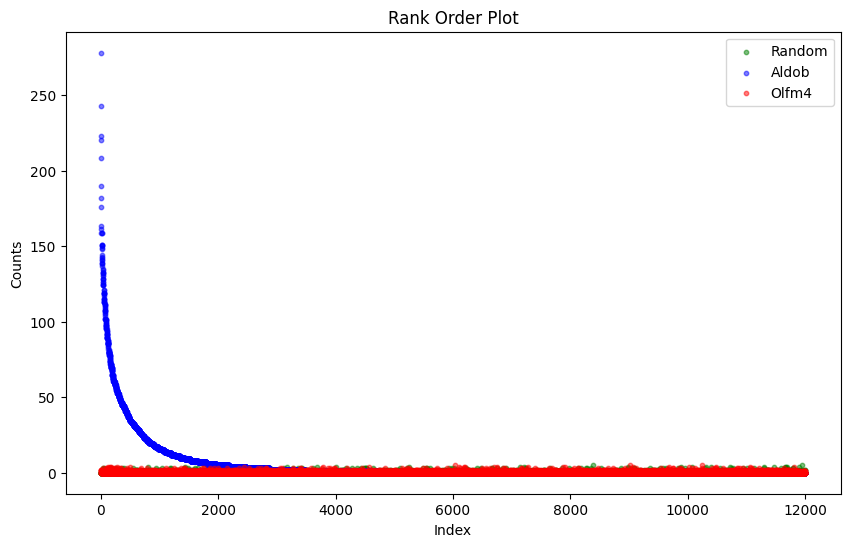

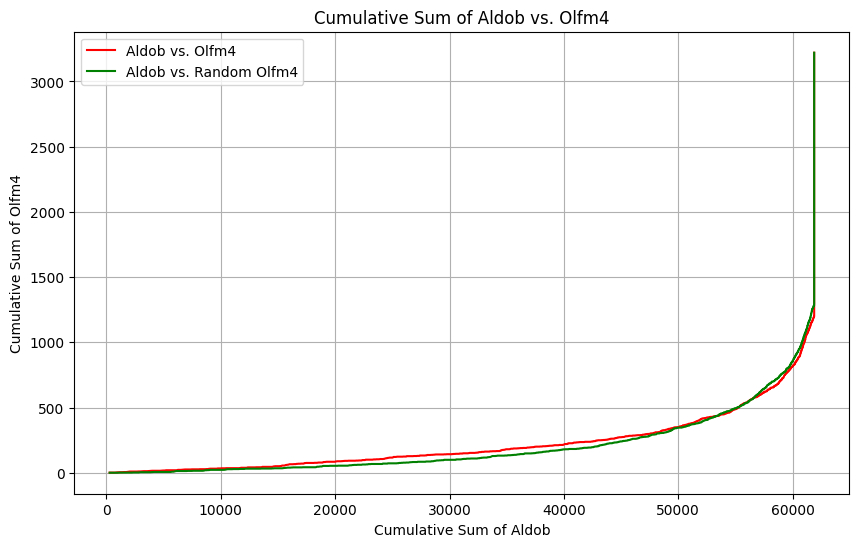

In [17]:
calculator.plot_hexbin('Aldob', 'Olfm4')
calculator.plot_rank_orders('Aldob', 'Olfm4')

In [20]:
# Compute pairwise L-Metrics for all genes
calculator.compute_pairwise_l_metrics()
pprint.pprint(calculator.l_metric_matrix.head())

Computing Pairwise L-Metrics: 100%|██████████| 19460/19460 [00:20<00:00, 959.96it/s] 


            Ada      Add3     Adh6a      Agr2     Ahnak   Aldh1b1     Aldob  \
Ada    0.000000 -0.010899  0.018578 -0.012539 -0.028717 -0.012924  0.164455   
Add3  -0.007157  0.000000  0.084108  0.054304  0.006971  0.064763  0.096404   
Adh6a -0.000106  0.015138  0.000000  0.012636  0.004227  0.020739  0.051872   
Agr2  -0.003048  0.013088 -0.002988  0.000000 -0.004253  0.008774  0.021512   
Ahnak -0.151043  0.015370  0.043375 -0.109244  0.000000  0.078263 -0.178792   

           Alpi      Ang4     Anxa1  ...      Tff3   Tm4sf20    Tm4sf4  \
Ada    0.212807 -0.011087 -0.030755  ...  0.010009  0.158725  0.107832   
Add3   0.066981  0.010980  0.007312  ...  0.006089  0.095489  0.021567   
Adh6a  0.043811  0.015715  0.015313  ... -0.003510  0.063908  0.006639   
Agr2   0.000317  0.043391 -0.013315  ...  0.139318  0.017253  0.006586   
Ahnak -0.154511  0.127877  0.180594  ...  0.003675 -0.142386 -0.043313   

           Tph1    Tuba1a    Txndc5       Vim      Yap1   Zfp36l2      Zg16  
Ad

In [21]:
# Perform hierarchical clustering using the average linkage method and Euclidean distance
calculator.perform_clustering(method='average', metric='euclidean')

# Plot the interactive clustered heatmap
calculator.plot_heatmap(interactive=True)

# Filtering

We can also apply filters that will apply to all functions. You can name the filter, or just add a default filter. Examples below.

Filter added to obs DataFrame under column 'default_filter'.
*** NOTE: default_filter being applied, using 1345 of 12007 total objects ***


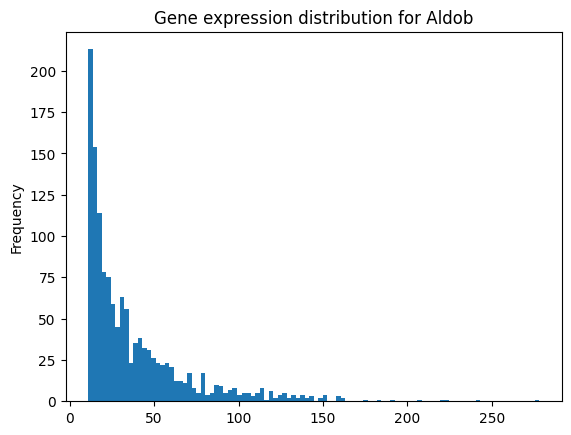

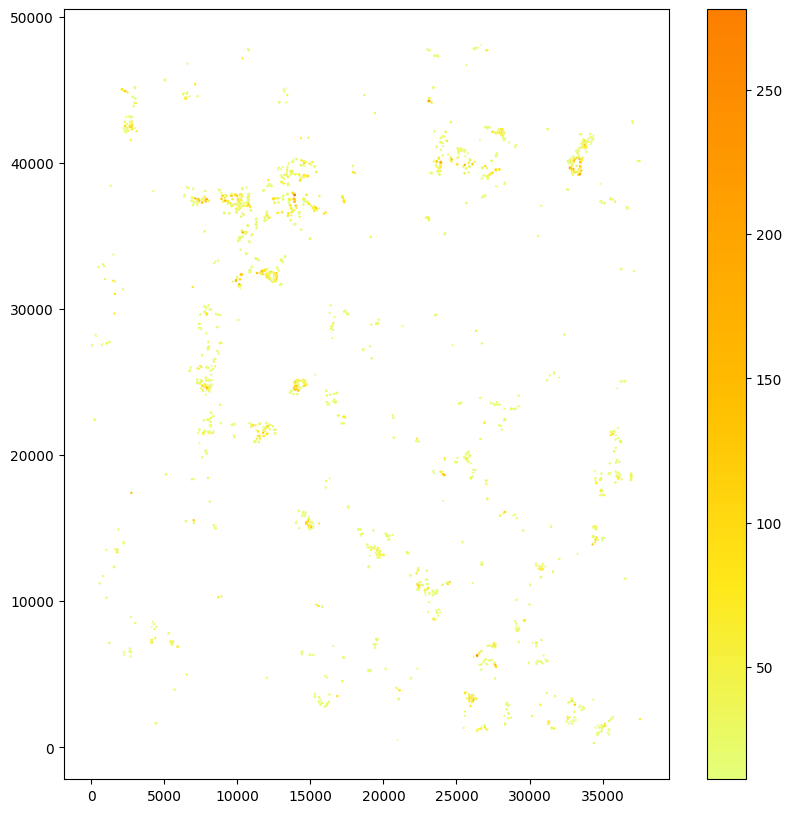

Statistics for gene Aldob: count    1345.000000
mean       38.077323
std        32.781632
min        11.000000
25%        16.000000
50%        26.000000
75%        47.000000
max       278.000000
Name: Aldob, dtype: float64
Number of objects expressing Aldob: 1345 out of 1345 (100.00%)


In [16]:
df = sg_obj.get_cell_gene_table_df(use_filter=False) # Make sure it's false for now in case there are existing filters
sg_obj.add_filter(df['Aldob']>10)
sg_obj.show_gene_stats_plots("Aldob")

You can add multiple filters and choose specific ones to apply.

Filter added to obs DataFrame under column 'Chga_filter'.
*** NOTE: Chga_filter being applied, using 65 of 12007 total objects ***
Rows in filtered table:  65
*** NOTE: Chga_filter being applied, using 65 of 12007 total objects ***


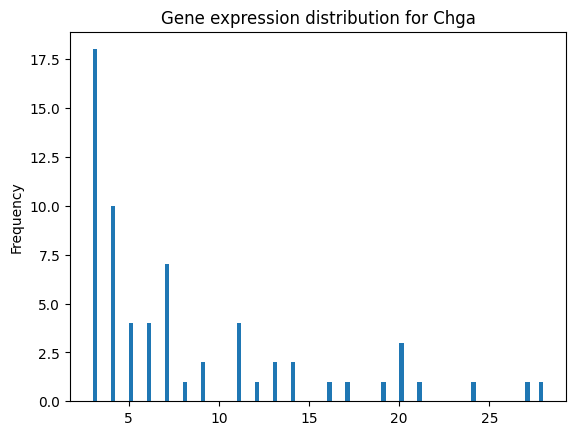

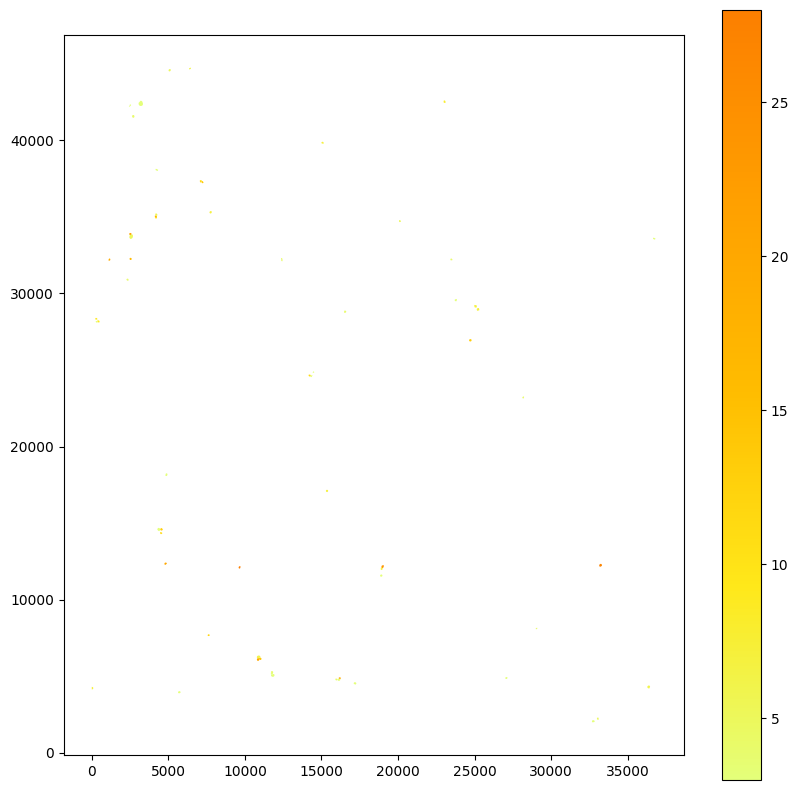

Statistics for gene Chga: count    65.000000
mean      8.230769
std       6.525836
min       3.000000
25%       3.000000
50%       6.000000
75%      11.000000
max      28.000000
Name: Chga, dtype: float64
Number of objects expressing Chga: 65 out of 65 (100.00%)


In [17]:
df = sg_obj.get_cell_gene_table_df(use_filter=False) # Make sure it's false for now in case there are existing filters
sg_obj.add_filter(df['Chga']>2,filter_column="Chga_filter")
df = sg_obj.get_cell_gene_table_df(use_filter="Chga_filter")
print("Rows in filtered table: ", len(df))
sg_obj.show_gene_stats_plots("Chga",use_filter="Chga_filter") # Note: if you don't specify use_filter, it will use the default, which was for Aldob

You can clear filters, too.

In [18]:
sg_obj.remove_filters() # Removes all filters
df = sg_obj.get_cell_gene_table_df() # This should now be completely unfiltered by default
print("Rows in unfiltered table: ", len(df))

All filters removed from obs DataFrame.
No filtering available or applied.
Rows in unfiltered table:  12007


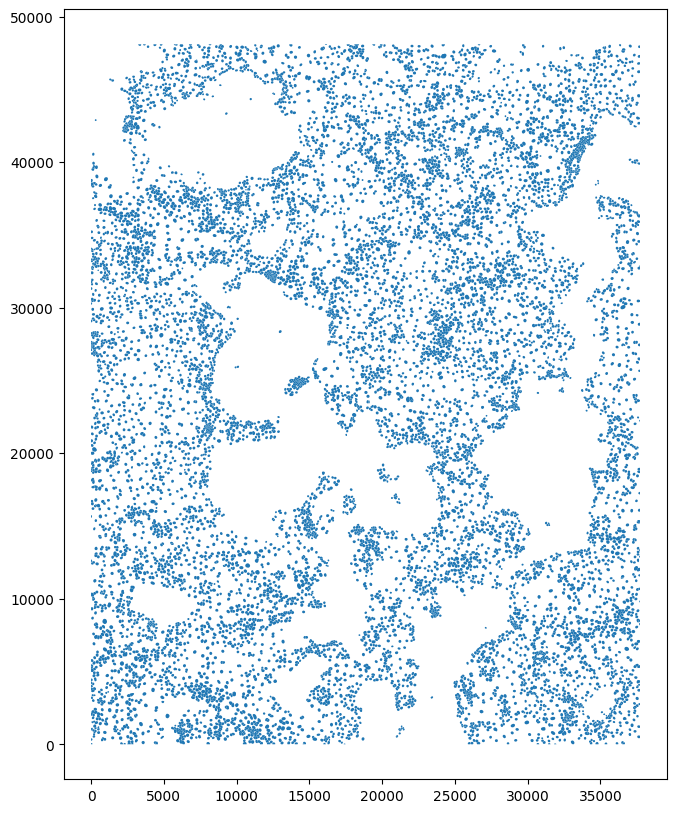

In [19]:
sg_obj.gdf.plot(figsize=(10, 10))
plt.show()

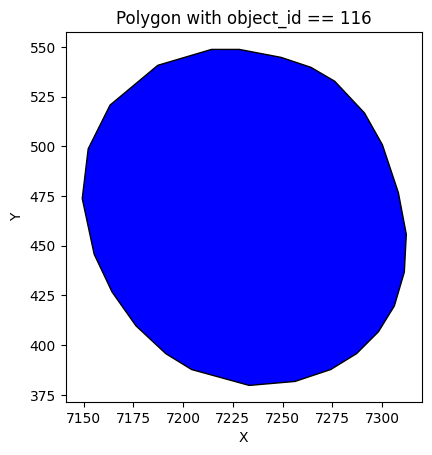

In [20]:
sg_obj.plot_polygon_by_id('116')

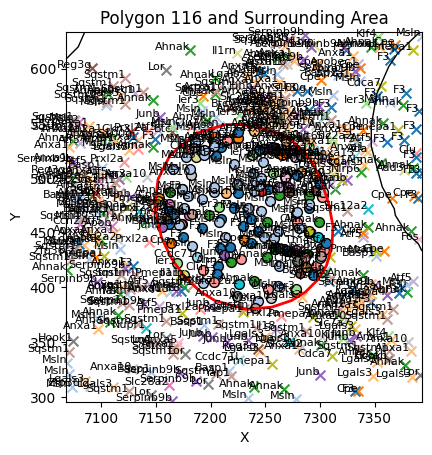

In [21]:

sg_obj.plot_polygon_and_points('116')

**Now let's load Cat's data, which was segmented in NimbusImage and exported as JSON.**

In [3]:
# Now try the JSON file and working with Cat's data

json_file = '/Users/arjunraj/code/convert_masks_SG/hyb_1_aligned_20240219-test-segmentation.json'
sg_obj2 = SGobject()
sg_obj2.nimbus_json_to_objects(json_file)
print(sg_obj2.gdf.head())

                  object_id                                            nucleus
0  65d3a2a53f73fc2469cc3ab5  POLYGON ((4972.000 1802.000, 4936.000 1826.000...
1  65d3a2a53f73fc2469cc3ab6  POLYGON ((4789.000 1823.000, 4768.000 1828.000...
2  65d3a2a53f73fc2469cc3ab7  POLYGON ((5110.000 1854.000, 5078.000 1859.000...
3  65d3a2a53f73fc2469cc3ab8  POLYGON ((4368.000 1903.000, 4360.000 1906.000...
4  65d3a2a53f73fc2469cc3ab9  POLYGON ((4837.000 1911.000, 4815.000 1917.000...


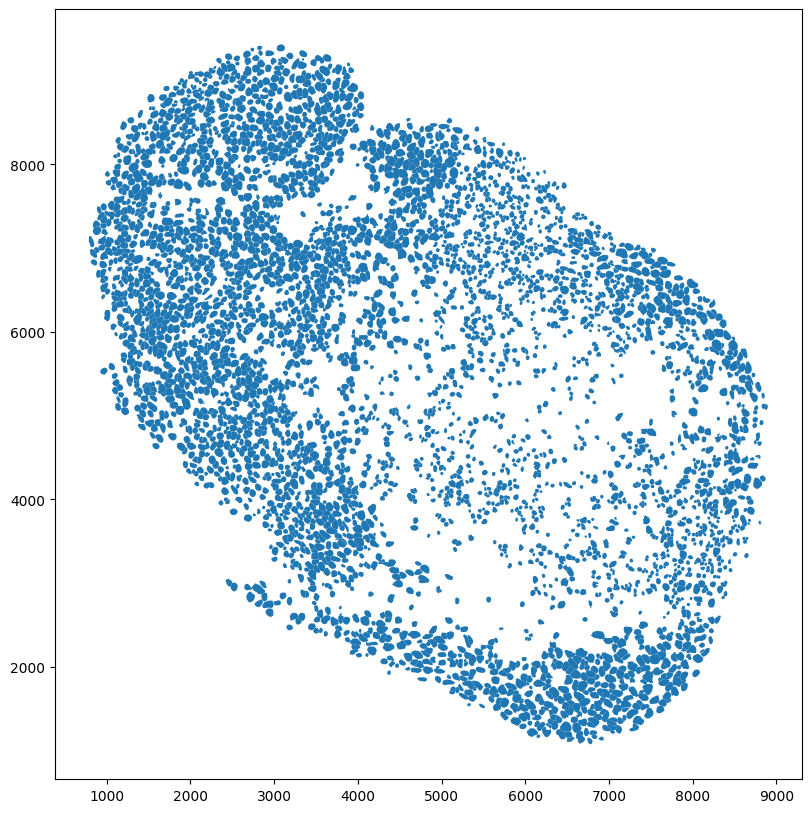

In [4]:
sg_obj2.gdf.plot(figsize=(10, 10))
plt.show()

Dilation completed. Output column: 'nucleus_dilated' is now the active geometry column.


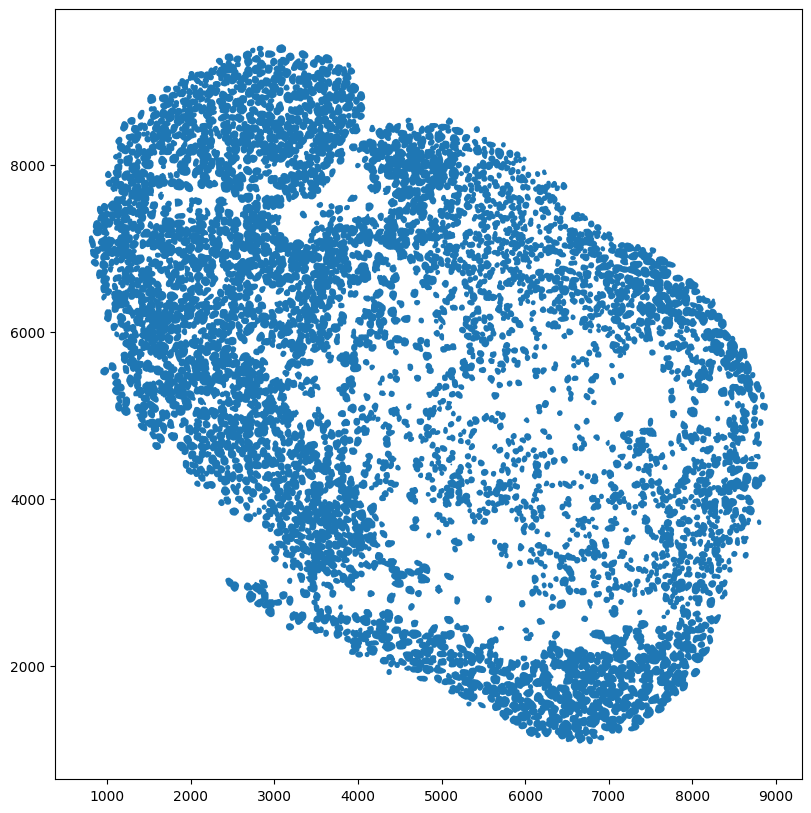

In [5]:
sg_obj2.dilate_objects(10)
sg_obj2.gdf.plot(figsize=(10, 10))
plt.show()

In [6]:
print(sg_obj2.gdf.head()) # Shows how the various shapes are stored in the GeoDataFrame

                  object_id  \
0  65d3a2a53f73fc2469cc3ab5   
1  65d3a2a53f73fc2469cc3ab6   
2  65d3a2a53f73fc2469cc3ab7   
3  65d3a2a53f73fc2469cc3ab8   
4  65d3a2a53f73fc2469cc3ab9   

                                             nucleus  \
0  POLYGON ((4972.000 1802.000, 4936.000 1826.000...   
1  POLYGON ((4789.000 1823.000, 4768.000 1828.000...   
2  POLYGON ((5110.000 1854.000, 5078.000 1859.000...   
3  POLYGON ((4368.000 1903.000, 4360.000 1906.000...   
4  POLYGON ((4837.000 1911.000, 4815.000 1917.000...   

                                     nucleus_dilated  
0  POLYGON ((4974.169 1792.238, 4973.176 1792.069...  
1  POLYGON ((4789.555 1813.015, 4788.591 1813.008...  
2  POLYGON ((5116.247 1846.191, 5115.405 1845.587...  
3  POLYGON ((4370.290 1893.266, 4369.324 1893.088...  
4  POLYGON ((4838.322 1901.088, 4837.328 1901.005...  


In [7]:
spot_file = '/Users/arjunraj/code/convert_masks_SG/test.csv'

sg_obj2.load_points(spot_file)
sg_obj2.create_cell_gene_table()
cell_gene_table_df = sg_obj2.get_cell_gene_table_df() # Table is an AnnData object, convert to dataframe for easy use
print(cell_gene_table_df.head())

428559 of 841314 spots (50.9%) assigned to an object.
No filtering available or applied.
name                      Abca7  Aldh1a2  Apoe  Atad2  Atm  Aurkb  Bad  Bax  \
object_id                                                                     
65d3a2a53f73fc2469cc3ab5      0        2     0      0    0      0    0    0   
65d3a2a53f73fc2469cc3ab6      0        0     0      0    0      0    0    0   
65d3a2a53f73fc2469cc3ab7      0        0     0      0    0      1    0    0   
65d3a2a53f73fc2469cc3ab8      0        0     0      0    0      0    0    0   
65d3a2a53f73fc2469cc3ab9      0        1     1      0    0      0    0    0   

name                      Bbc3  Bcl2  ...  Ung  Utf1  Vwf  Was  Wnt3a  Wnt5a  \
object_id                             ...                                      
65d3a2a53f73fc2469cc3ab5     0     0  ...    1     0    1    0      0      0   
65d3a2a53f73fc2469cc3ab6     0     0  ...    0     0    0    0      0      0   
65d3a2a53f73fc2469cc3ab7     0     0 

In [8]:
# the obs column should be the object_id; verify that this is a bunch of strings.
print(sg_obj2.cell_gene_table.obs)

Empty DataFrame
Columns: []
Index: [65d3a2a53f73fc2469cc3ab5, 65d3a2a53f73fc2469cc3ab6, 65d3a2a53f73fc2469cc3ab7, 65d3a2a53f73fc2469cc3ab8, 65d3a2a53f73fc2469cc3ab9, 65d3a2a53f73fc2469cc3aba, 65d3a2a53f73fc2469cc3abb, 65d3a2a53f73fc2469cc3abc, 65d3a2a53f73fc2469cc3abd, 65d3a2a53f73fc2469cc3abe, 65d3a2a53f73fc2469cc3abf, 65d3a2a53f73fc2469cc3ac0, 65d3a2a53f73fc2469cc3ac1, 65d3a2a53f73fc2469cc3ac2, 65d3a2a53f73fc2469cc3ac3, 65d3a2a53f73fc2469cc3ac4, 65d3a2a53f73fc2469cc3ac5, 65d3a2a53f73fc2469cc3ac6, 65d3a2a53f73fc2469cc3ac7, 65d3a2a53f73fc2469cc3ac8, 65d3a2a53f73fc2469cc3ac9, 65d3a2a53f73fc2469cc3aca, 65d3a2a53f73fc2469cc3acb, 65d3a2a53f73fc2469cc3acc, 65d3a2a53f73fc2469cc3acd, 65d3a2a53f73fc2469cc3ace, 65d3a2a53f73fc2469cc3acf, 65d3a2a53f73fc2469cc3ad0, 65d3a2a53f73fc2469cc3ad1, 65d3a2a53f73fc2469cc3ad2, 65d3a2a53f73fc2469cc3ad3, 65d3a2a53f73fc2469cc3ad4, 65d3a2a53f73fc2469cc3ad5, 65d3a2a53f73fc2469cc3ad6, 65d3a2a53f73fc2469cc3ad7, 65d3a2a53f73fc2469cc3ad8, 65d3a2a53f73fc2469cc3ad9, 65

In [9]:
# Double check that the total number of elements of the gdf and the cell_gene_table are the same
print(len(sg_obj2.gdf))
print(len(sg_obj2.cell_gene_table))

4330
4288


In [10]:
print(sg_obj2.assigned_points_gdf.head())

         name               refid     x     y                   geometry  \
715623   Mest  ENSMUSG00000051855  5109  8023  POINT (5109.000 8023.000)   
252918   Nasp  ENSMUSG00000028693  8289  5844  POINT (8289.000 5844.000)   
649271   Mest  ENSMUSG00000051855  7463  1736  POINT (7463.000 1736.000)   
451701  Top2a  ENSMUSG00000020914  6478  1278  POINT (6478.000 1278.000)   
608846  Casp3  ENSMUSG00000031628  5147  7897  POINT (5147.000 7897.000)   

        index_right                 object_id  \
715623       4187.0  65d3a2a83f73fc2469cc4b1f   
252918       1934.0  65d3a2a73f73fc2469cc4249   
649271        192.0  65d3a2a53f73fc2469cc3b76   
451701         91.0  65d3a2a53f73fc2469cc3b10   
608846       4192.0  65d3a2a83f73fc2469cc4b24   

                                                  nucleus  distance_to_edge  
715623  POLYGON ((5089.000 7959.000, 5067.000 7969.000...         63.740115  
252918  POLYGON ((8314.000 5768.000, 8269.000 5791.000...         63.000000  
649271  POLYGO

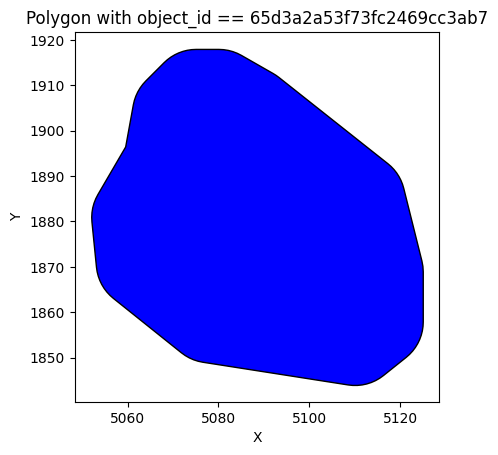

In [11]:
sg_obj2.plot_polygon_by_id("65d3a2a53f73fc2469cc3ab7")

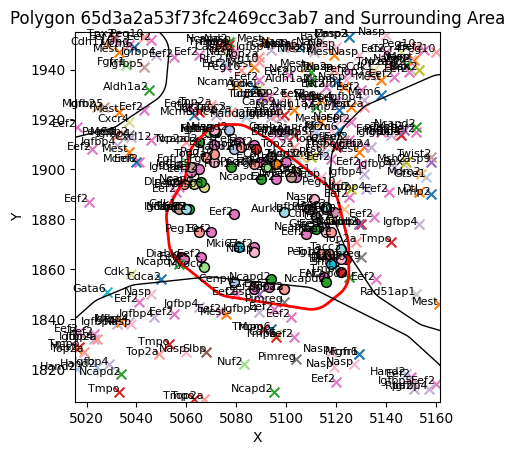

In [12]:
sg_obj2.plot_polygon_and_points("65d3a2a53f73fc2469cc3ab7")

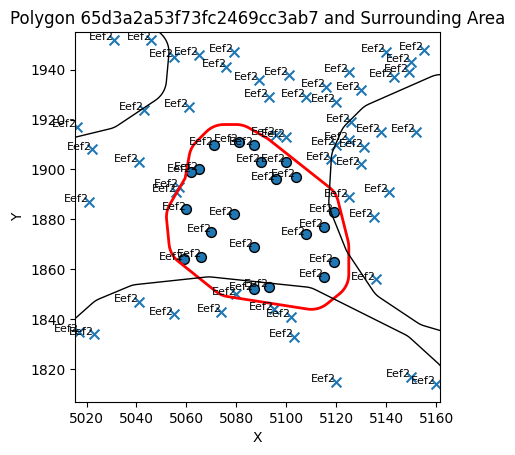

In [13]:
sg_obj2.plot_polygon_and_points("65d3a2a53f73fc2469cc3ab7", gene_names="Eef2")

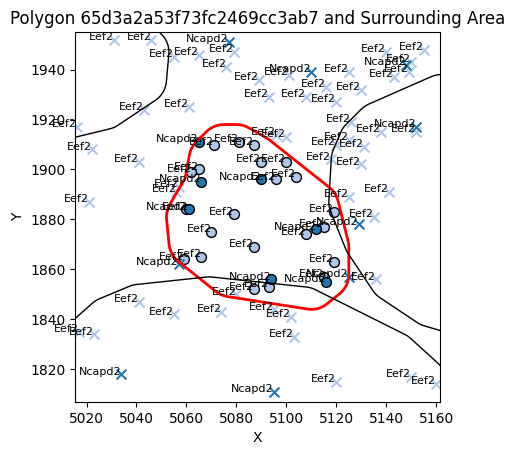

In [14]:
sg_obj2.plot_polygon_and_points("65d3a2a53f73fc2469cc3ab7", gene_names=["Eef2","Ncapd2"])

Number of objects: 4330
Number of points: 845413
Average number of points per object: 195.25
Percentage of points assigned to an object: 50.69%
Average number of assigned points per object: 98.97
Average number of unique genes detected per object: 25.81
Total number of genes detected: 221
Total number of genes detected (assigned to objects): 221


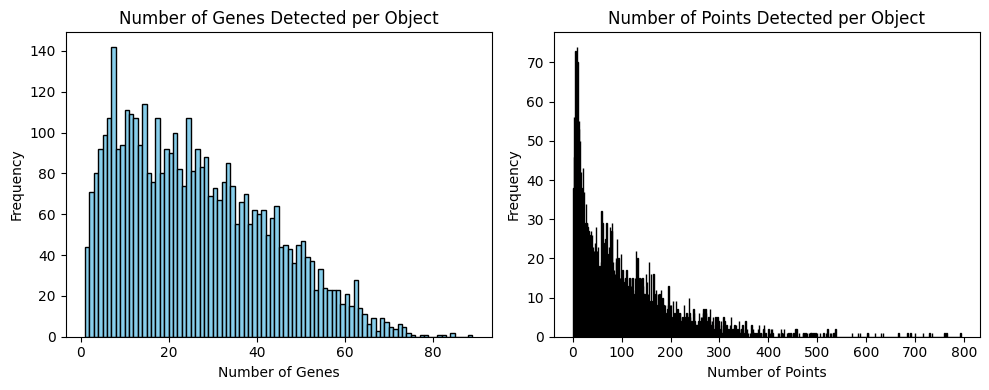

In [15]:
sg_obj2.generate_statistics_and_histograms()


No filtering available or applied.


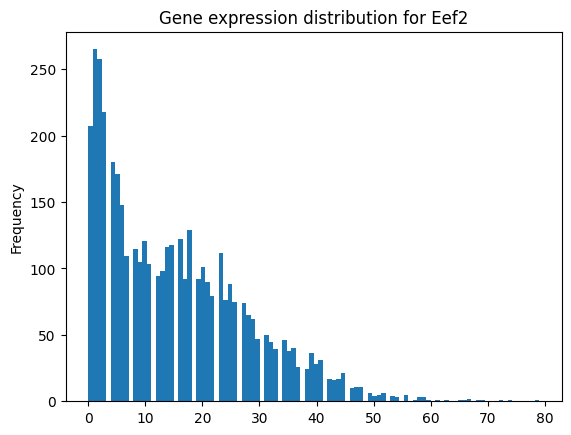

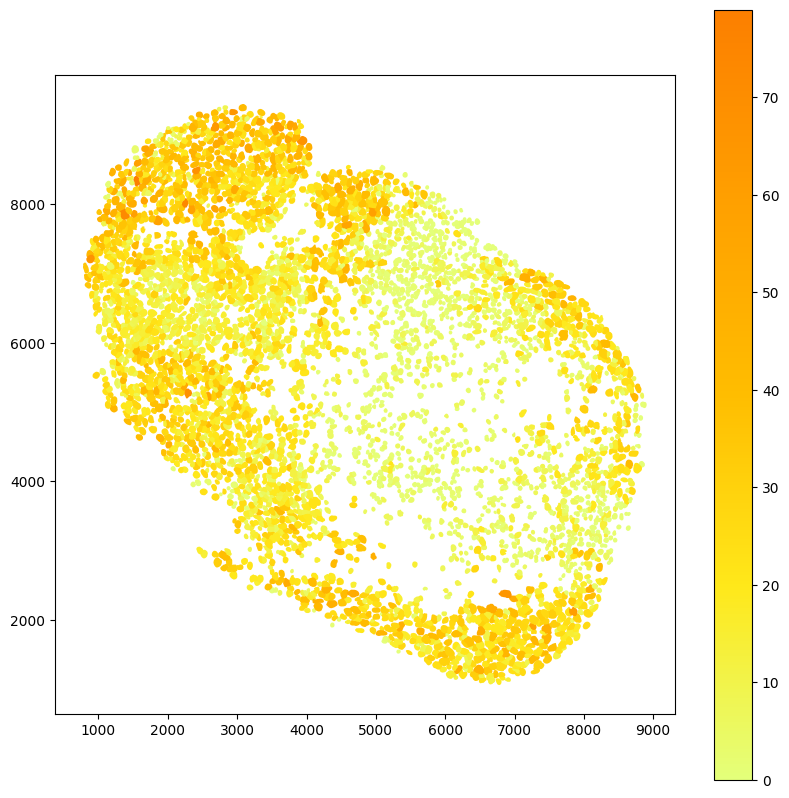

Statistics for gene Eef2: count    4288.000000
mean       15.225979
std        12.688017
min         0.000000
25%         4.000000
50%        13.000000
75%        23.000000
max        79.000000
Name: Eef2, dtype: float64
Number of objects expressing Eef2: 4081 out of 4288 (95.17%)


In [16]:
sg_obj2.show_gene_stats_plots("Eef2")

In [11]:
# Exports all objects and selected RNA points (here Sox2) to JSON for import into NimbusImage for viewing
# Note: by default, exports polygons to channel 3 and points to channel 0. This assumes that DAPI is channel 3.
# When you upload the data to Nimbus, you will want to use "comprehensive upload", then clear the "z" and assign instead to "C".
# Ask Arjun if you're confused.

sg_obj2.export_to_nimbus_json('/Users/arjunraj/code/convert_masks_SG/hyb_1_aligned_20240219-test-segmentation-dilated_genes.json', gene_names=["Sox2","Top2a"],include_connections=True, export_gene_counts=True)

Exporting gene counts: ['Sox2', 'Top2a']
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write propert

/Users/arjunraj/code/SGanalysis/SGanalysis/SGobject.py:877: UserWarning: Object ID 65d3a2a53f73fc2469cc3b13 not found in cell_gene_table. Skipping gene counts for this object.
  warnings.warn(f"Object ID {object_id} not found in cell_gene_table. Skipping gene counts for this object.")
/Users/arjunraj/code/SGanalysis/SGanalysis/SGobject.py:877: UserWarning: Object ID 65d3a2a53f73fc2469cc3b24 not found in cell_gene_table. Skipping gene counts for this object.
  warnings.warn(f"Object ID {object_id} not found in cell_gene_table. Skipping gene counts for this object.")
/Users/arjunraj/code/SGanalysis/SGanalysis/SGobject.py:877: UserWarning: Object ID 65d3a2a53f73fc2469cc3bda not found in cell_gene_table. Skipping gene counts for this object.
  warnings.warn(f"Object ID {object_id} not found in cell_gene_table. Skipping gene counts for this object.")
/Users/arjunraj/code/SGanalysis/SGanalysis/SGobject.py:877: UserWarning: Object ID 65d3a2a53f73fc2469cc3c97 not found in cell_gene_table. Skip

Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write property values
Write prop

/Users/arjunraj/code/SGanalysis/SGanalysis/SGobject.py:877: UserWarning: Object ID 65d3a2a73f73fc2469cc46a5 not found in cell_gene_table. Skipping gene counts for this object.
  warnings.warn(f"Object ID {object_id} not found in cell_gene_table. Skipping gene counts for this object.")
/Users/arjunraj/code/SGanalysis/SGanalysis/SGobject.py:877: UserWarning: Object ID 65d3a2a83f73fc2469cc473a not found in cell_gene_table. Skipping gene counts for this object.
  warnings.warn(f"Object ID {object_id} not found in cell_gene_table. Skipping gene counts for this object.")
/Users/arjunraj/code/SGanalysis/SGanalysis/SGobject.py:877: UserWarning: Object ID 65d3a2a83f73fc2469cc4745 not found in cell_gene_table. Skipping gene counts for this object.
  warnings.warn(f"Object ID {object_id} not found in cell_gene_table. Skipping gene counts for this object.")
/Users/arjunraj/code/SGanalysis/SGanalysis/SGobject.py:877: UserWarning: Object ID 65d3a2a83f73fc2469cc4749 not found in cell_gene_table. Skip

Exported to JSON: /Users/arjunraj/code/convert_masks_SG/hyb_1_aligned_20240219-test-segmentation-dilated_genes.json
Total annotations: 55090
Total connections: 23854
Exported counts for 2 genes


scanpy integration!

In [11]:
# Let's do some cell cycle analysis

s_genes = [
    'Fen1', 'Mcm2', 'Mcm4', 'Rrm1', 'Ung', 'Gins2', 'Mcm6', 'Cdca7', 'Dtl', 'Mlf1ip',
    'Hells', 'Rfc2', 'Rpa2', 'Nasp', 'Rad51ap1', 'Slbp', 'Ccne2', 'Ubr7', 'Pold3', 
    'Msh2', 'Atad2'
]

g2m_genes = [
    'Hmgb2', 'Cdk1', 'Nusap1', 'Tpx2', 'Top2a', 'Nuf2', 'Mki67', 'Tmpo', 'Cenpf', 'Tacc3',
    'Fam64a', 'Smc4', 'Ccnb2', 'Ckap2', 'Aurkb', 'Bub1', 'Kif11', 'Gtse1', 'Kif20b',
    'Hjurp', 'Cdca3', 'Cdc25c', 'Kif2c', 'Rangap1', 'Ncapd2', 'Dlgap5', 'Cdca2'
]

# Score cell cycle and assign cells using scanpy
sc.tl.score_genes_cell_cycle(sg_obj2.cell_gene_table, s_genes=s_genes, g2m_genes=g2m_genes)
print(sg_obj2.cell_gene_table.obs.head()) # obs is the cell annotation dataframe

                           S_score  G2M_score phase
object_id                                          
65d3a2a53f73fc2469cc3ab5  0.175000  -0.658921     S
65d3a2a53f73fc2469cc3ab6  0.068182  -0.404423     S
65d3a2a53f73fc2469cc3ab7 -0.177273   0.647301   G2M
65d3a2a53f73fc2469cc3ab8 -0.011364   0.034858   G2M
65d3a2a53f73fc2469cc3ab9  0.275000   1.272864   G2M


In [12]:
# Let's plot the objects with the cell cycle scores as colors

# First, list all possible things to plot
print(sg_obj2.get_observation_list())

['S_score', 'G2M_score', 'phase']


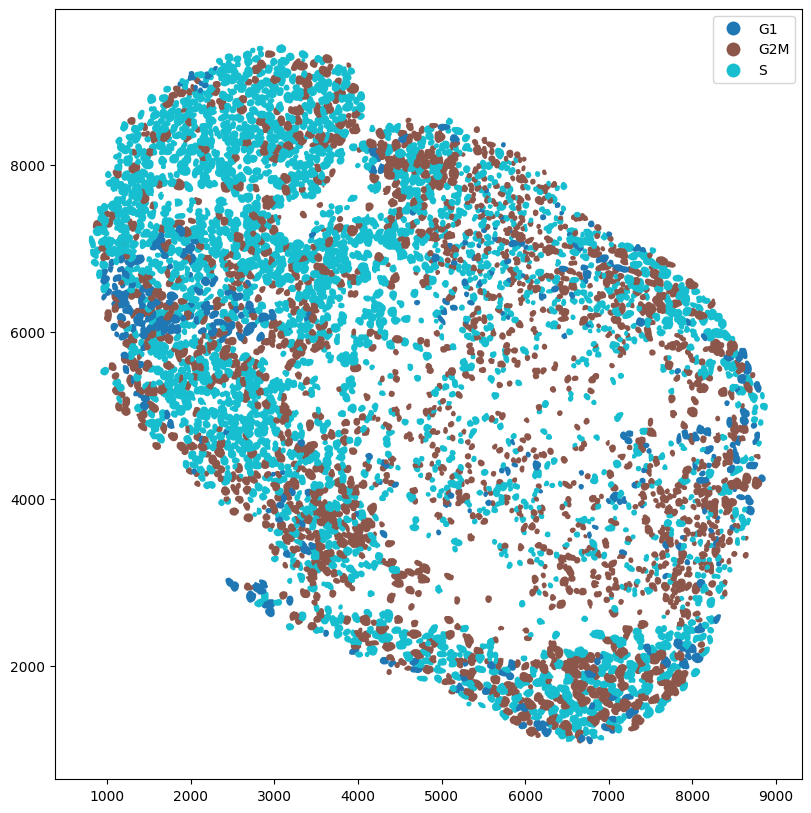

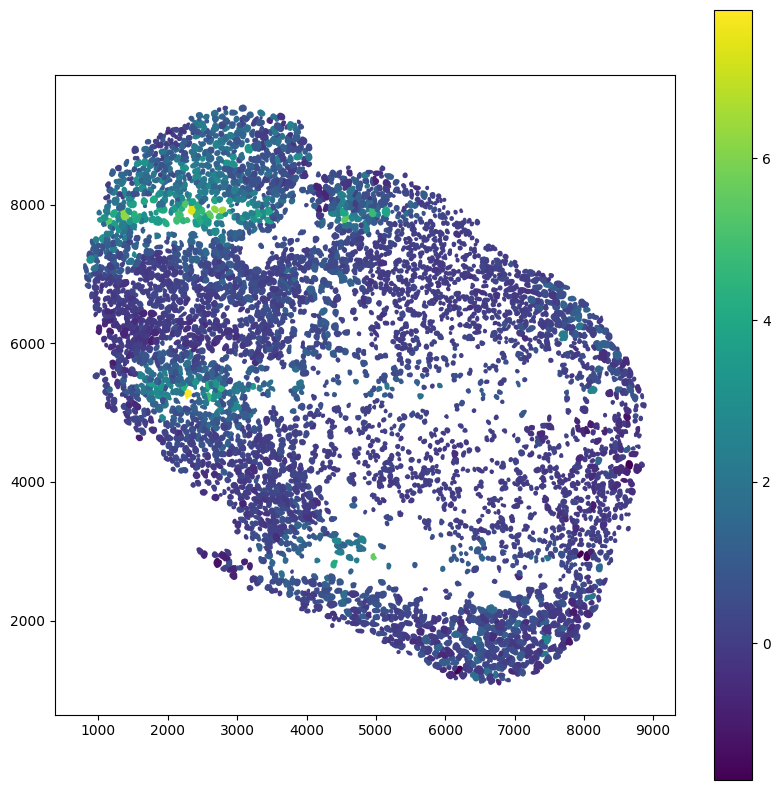

In [13]:
sg_obj2.plot_observation_variable('phase')
sg_obj2.plot_observation_variable('S_score')

In [15]:
# Export to Nimbus can also include the observation variable.
# If the observation variable is categorical, it will be exported as a tag.
# If it is continuous, it will be exported as a property/property value.
# Exports all objects and selected RNA points (here Sox2) to JSON for import into NimbusImage for viewing
# Note: by default, exports polygons to channel 3 and points to channel 0. This assumes that DAPI is channel 3.
# When you upload the data to Nimbus, you will want to use "comprehensive upload", then clear the "z" and assign instead to "C".
# Ask Arjun if you're confused.

sg_obj2.export_to_nimbus_json('/Users/arjunraj/code/convert_masks_SG/hyb_1_aligned_20240219-test-segmentation-dilated_phase.json', gene_names=["Sox2","Bub1","Ccne2","Hjurp"],include_connections=True, obs_variable="phase", export_gene_counts=None)


Exporting_gene_counts: []


/Users/arjunraj/code/SGanalysis/SGanalysis/SGobject.py:853: UserWarning: Object ID 65d3a2a53f73fc2469cc3b13 not found in cell_gene_table.obs. Skipping obs_variable for this object.
  warnings.warn(f"Object ID {row['object_id']} not found in cell_gene_table.obs. Skipping obs_variable for this object.")
/Users/arjunraj/code/SGanalysis/SGanalysis/SGobject.py:853: UserWarning: Object ID 65d3a2a53f73fc2469cc3b24 not found in cell_gene_table.obs. Skipping obs_variable for this object.
  warnings.warn(f"Object ID {row['object_id']} not found in cell_gene_table.obs. Skipping obs_variable for this object.")
/Users/arjunraj/code/SGanalysis/SGanalysis/SGobject.py:853: UserWarning: Object ID 65d3a2a53f73fc2469cc3bda not found in cell_gene_table.obs. Skipping obs_variable for this object.
  warnings.warn(f"Object ID {row['object_id']} not found in cell_gene_table.obs. Skipping obs_variable for this object.")
/Users/arjunraj/code/SGanalysis/SGanalysis/SGobject.py:853: UserWarning: Object ID 65d3a2a5

Exported to JSON: /Users/arjunraj/code/convert_masks_SG/hyb_1_aligned_20240219-test-segmentation-dilated_phase.json
Total annotations: 6311
Total connections: 1121
Added coloring and properties based on 'phase'


When you import to NimbusImage, now it will add in the phase information. Allows you to visualize these differences.
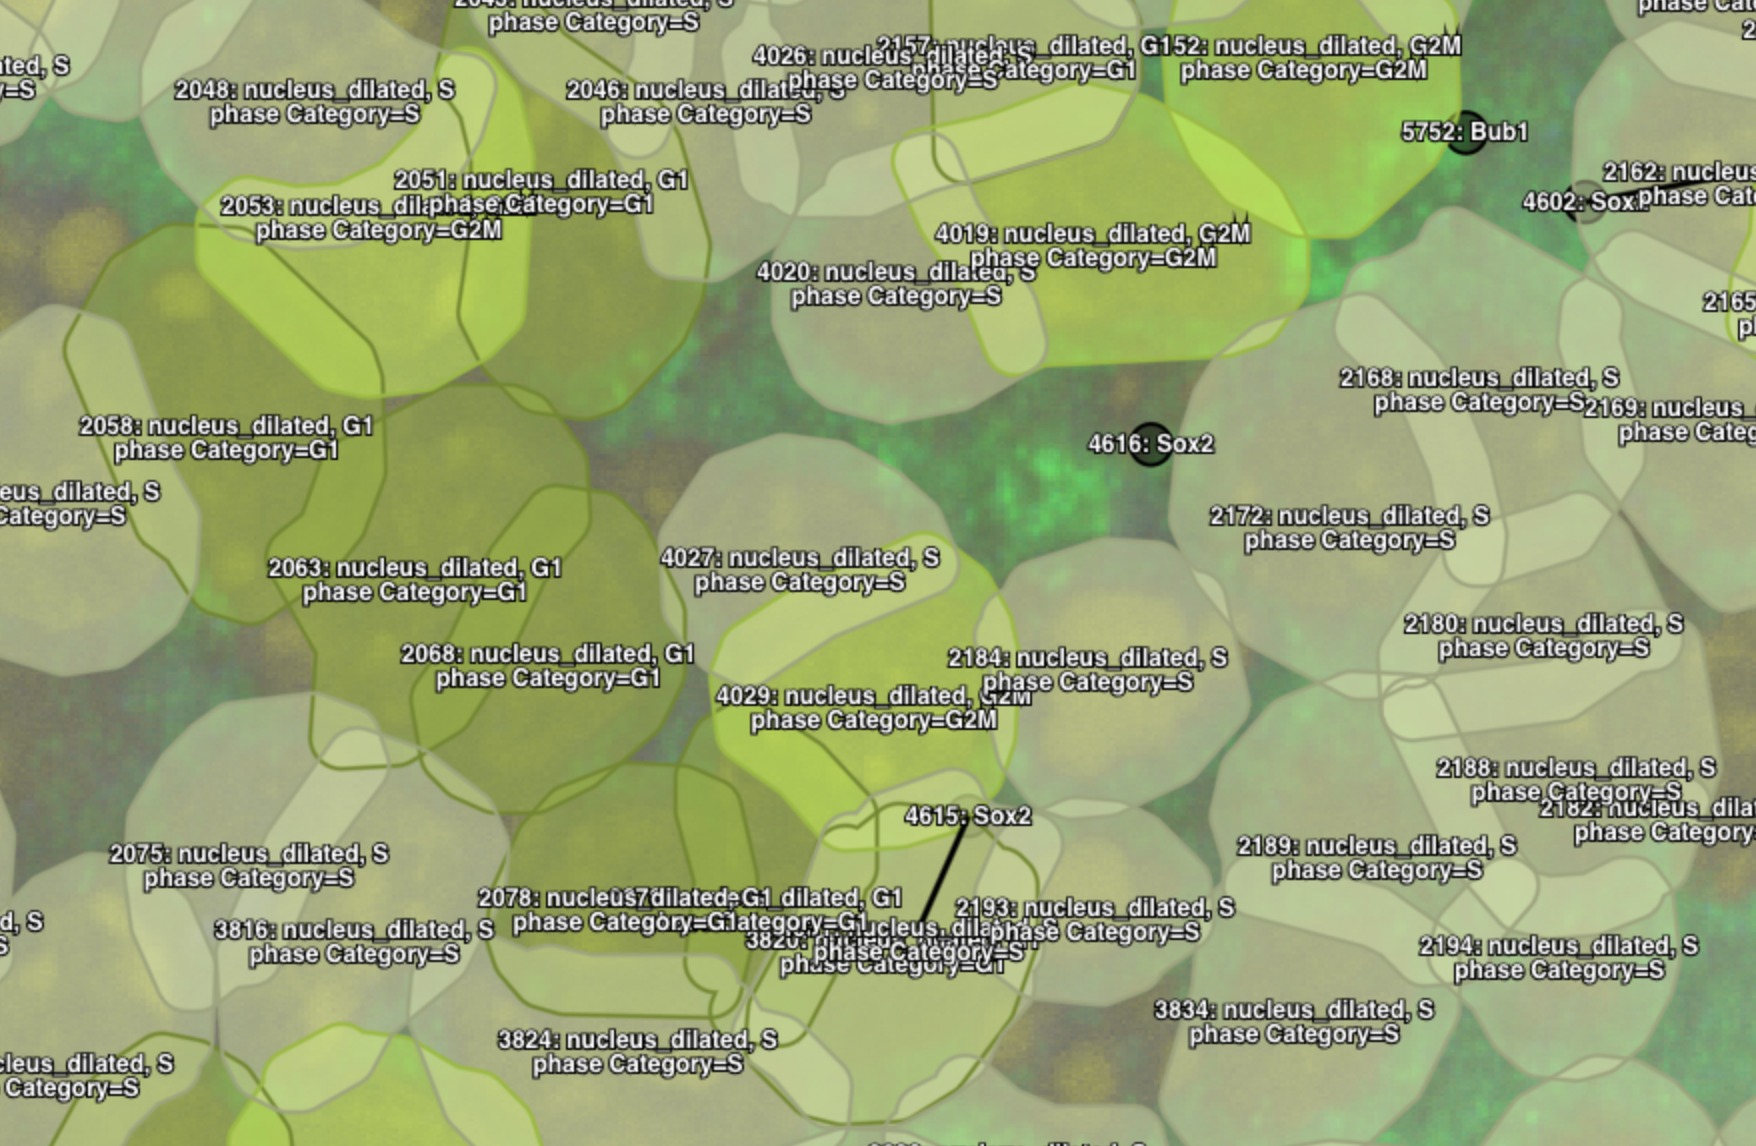

In [40]:

# Save the GeoDataFrame as a GeoJSON file
print("Running save_polygons")
sg_obj.save_geojson_polygons('output_polygons.geojson')


Running save_polygons


In [41]:

# Load polygons from a GeoJSON file (optional)
print("Running load_polygons")
sg_obj.load_geojson_polygons('output_polygons.geojson')


Running load_polygons
